In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Conv2D

In [2]:
mnist = tf.keras.datasets.mnist
cifar10 =  tf.keras.datasets.cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = x_train / 255.0
x_test = x_test/255.0

x_train = x_train[..., tf.newaxis]#.astype(int)
x_test = x_test[..., tf.newaxis]

170498071/170498071 [==============================] - 4s 0us/step


In [3]:
print(x_train[0].shape)
print(x_test[0].shape)

(32, 32, 3, 1)
(32, 32, 3, 1)


In [4]:
type(x_train[0])

numpy.ndarray

(32, 32, 3)


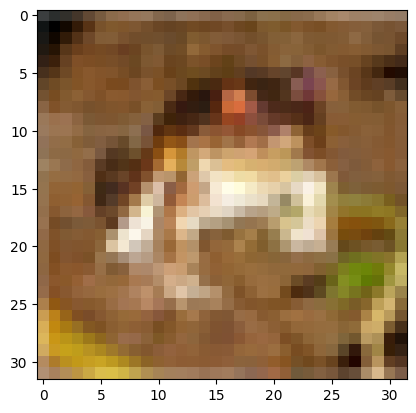

In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
image = x_train[0, :, :, :]
image = tf.squeeze(image, 3)
print(image.shape)
# image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.show()

In [6]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(1000).batch(32)
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(32)

In [7]:
class MyModel(tf.keras.Model):
  def __init__(self):
    super().__init__()
    self.conv1 = Conv2D(32, 3, activation="relu", padding = 'same')
    self.conv2 = Conv2D(64, 3, activation="relu", padding = 'same')
    self.conv3 = Conv2D(64, 3, activation="relu")
    self.conv4 = Conv2D(32, 3, activation="relu")
    self.conv5 = Conv2D(32, 3, activation="relu")
    self.conv6 = Conv2D(16, 3, activation="relu")
    self.pooling1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))
    self.pooling2 = tf.keras.layers.AveragePooling2D(pool_size=(2, 2))
    self.pooling3 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))
    self.batch1 = tf.keras.layers.BatchNormalization()
    self.batch2 = tf.keras.layers.BatchNormalization()
    self.dropout1 = tf.keras.layers.Dropout(0.2)
    self.flatten = Flatten()
    self.d1 = Dense(128, activation="relu")
    self.d2 = Dense(256, activation="relu")
    self.d3 = Dense(10, activation="softmax")

  def call(self, x):
    x = self.conv1(x)
    x = self.conv2(x)
    x = self.pooling1(x)
    x = self.conv3(x)
    x = self.batch1(x)
    x = self.conv4(x)
    x = self.pooling2(x)
    x = self.conv5(x)
    x = self.conv6(x)
    x = self.batch2(x)
    x = self.pooling3(x)
    x = self.flatten(x)
    x = self.d2(x)
    x = self.d1(x)
    x = self.dropout1(x)
    x = self.d3(x)

    return x

model = MyModel()


In [8]:
loss_function = tf.keras.losses.SparseCategoricalCrossentropy()#from_logits=True)

optimizer = tf.keras.optimizers.Adam()

In [9]:
train_loss = tf.keras.metrics.Mean()
test_loss = tf.keras.metrics.Mean()

train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()

In [10]:
@tf.function
def train(images, labels):
    with tf.GradientTape() as tape:
      pred = model(images)
      loss = loss_function(labels, pred)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    train_loss(loss)
    train_accuracy(labels, pred)

In [11]:
@tf.function
def test(image, label):
    pred = model(image)
    loss = loss_function(label, pred)
    test_loss(loss)
    test_accuracy(label, pred)


In [12]:
epochs = 15
best_accuracy = 0
for epoch in range(epochs):
  train_loss.reset_states()
  train_accuracy.reset_states()
  test_loss.reset_states()
  test_accuracy.reset_states()

  for images, labels in train_dataset:
    images = tf.squeeze(images, 4)
    train(images, labels)

    #test
  for image, label in test_dataset:
    image = tf.squeeze(image, 4)
    test(image, label)
  if test_accuracy.result() > best_accuracy:
    model.save("cifar10_best_model")
    best_accuracy = test_accuracy.result()
  print("epoch:", epoch+1,
        f"Train Loss: {train_loss.result()}",
        f"Train accuracy: {train_accuracy.result()}",
        f"Test Loss: {test_loss.result()}",
        f"Test accuracy, {test_accuracy.result()}")

epoch: 1 Train Loss: 1.6489875316619873 Train accuracy: 0.38593998551368713 Test Loss: 1.3377329111099243 Test accuracy, 0.5051000118255615
epoch: 2 Train Loss: 1.2259552478790283 Train accuracy: 0.5569800138473511 Test Loss: 1.1398799419403076 Test accuracy, 0.5938000082969666
epoch: 3 Train Loss: 1.0457795858383179 Train accuracy: 0.6247400045394897 Test Loss: 1.044756531715393 Test accuracy, 0.6287999749183655
epoch: 4 Train Loss: 0.92646324634552 Train accuracy: 0.6689599752426147 Test Loss: 0.9244273900985718 Test accuracy, 0.6754999756813049
epoch: 5 Train Loss: 0.8452845215797424 Train accuracy: 0.6982799768447876 Test Loss: 0.8777270913124084 Test accuracy, 0.682699978351593
epoch: 6 Train Loss: 0.7783346176147461 Train accuracy: 0.7249799966812134 Test Loss: 0.835374653339386 Test accuracy, 0.7095999717712402
epoch: 7 Train Loss: 0.7213321328163147 Train accuracy: 0.7454800009727478 Test Loss: 0.9004119634628296 Test accuracy, 0.7002000212669373
epoch: 8 Train Loss: 0.68604969

In [ ]:

import cv2
import numpy as np

image = cv2.imread("frog.jpg")
# image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
image = cv2.resize(image, (32, 32))
# image = image[..., tf.newaxis]
image = image[tf.newaxis, ...]
image = image.astype("float32")

pred = model(image)
pred = abs(pred)
print(abs(pred))
result = np.argmax(pred)
labels = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]
labels[result]

In [ ]:
model.save("my_model")

In [ ]:
bestmodel = tf.keras.models.load_model("cifar10_best_model")

In [ ]:
for image, label in test_dataset:
  image = tf.squeeze(image, 4)
  pred = bestmodel(image)
  loss = loss_function(label, pred)
  test_loss(loss)
  test_accuracy(label, pred)

print( f"Test Loss: {test_loss.result()}",
      f"Test accuracy, {test_accuracy.result()}")